In [1]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


from spektral.data import Dataset, Graph, DisjointLoader
from spektral.layers import ECCConv, GCSConv, GCNConv, GlobalAvgPool, GlobalSumPool 
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj

from sklearn.metrics import classification_report

import json

import sys
sys.path.insert(1, '../src/')
from datasets import L3VPN_dataset, CEPE_dataset, PEs_dataset
import CEPE_model, PEs_model
import plot_reports

In [2]:
################################################################################
# PARAMETERS
################################################################################
n_customers = 1000 # number of customers (samples)
n_pe = 20 # number of PEs nodes on MPLS Backbone
n_ce_min = 10 # Minimum number of CEs node per customer
n_ce_max = 30 # Maximum number of CEs node per customer
VPN_Type = 2  # 0:Full-mesh; 1:Hub&Spoke; 2:Both
learning_rate = 1e-3  # Learning rate
epochs = 1000  # Number of training epochs
es_patience = 50  # Patience for early stopping
batch_size = 32  # Batch size
pes_channels = 64
cepe_channels = 64   # Number of channels at GC layer
gc_layer = "GCN" # Graph conventionel layer

In [3]:
%%time
################################################################################
# Generate DATA
################################################################################

l3vpn_dataset = L3VPN_dataset(n_samples=n_customers, n_pe=n_pe, n_ce_min=n_ce_min, n_ce_max=n_ce_max, VPN_Type=VPN_Type)
pes_dataset = PEs_dataset(l3vpn_dataset)
cepe_dataset = CEPE_dataset(l3vpn_dataset, n_faults=29)

CPU times: user 2min 31s, sys: 1.35 s, total: 2min 32s
Wall time: 2min 31s


In [4]:
cepe_dataset

CEPE_dataset(n_graphs=20013)

In [5]:
################################################################################
# Train/valid/test split : PEs Dataset
################################################################################

idxs = np.random.permutation(len(pes_dataset))
split_va, split_te = int(0.7 * len(pes_dataset)), int(0.8 * len(pes_dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
pes_dataset_tr = pes_dataset[idx_tr]
pes_dataset_va = pes_dataset[idx_va]
pes_dataset_te = pes_dataset[idx_te]

In [6]:
################################################################################
# Train/valid/test split : CE-PE routing Dataset
################################################################################

idxs = np.random.permutation(len(cepe_dataset))
split_va, split_te = int(0.7 * len(cepe_dataset)), int(0.8 * len(cepe_dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
cepe_dataset_tr = cepe_dataset[idx_tr]
cepe_dataset_va = cepe_dataset[idx_va]
cepe_dataset_te = cepe_dataset[idx_te]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 8)]          0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
E_in (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Message_passing_layer_1 (ECCCon (None, 64)           1600        X_in[0][0]                       
                                                                 A_in[0][0]                   

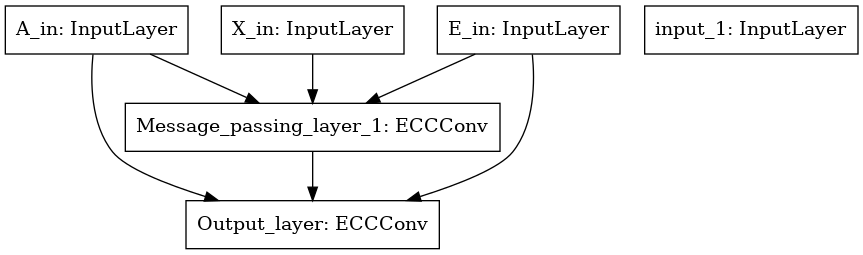

In [7]:
################################################################################
# BUILD MODEL : PEs Model
################################################################################

# Dataset parameters
NF = pes_dataset.n_node_features  # Dimension of node features
EF = pes_dataset.n_edge_features  # Dimension of edge features
n_out = pes_dataset.n_labels  # Dimension of the target

# optimizer and loss function (same as CE-PE routing model)
#opt = Adam(lr=learning_rate)
#loss_fn = CategoricalCrossentropy()

pes_model = PEs_model.create_model(n_node_features=NF, n_edge_features=EF, n_labels=n_out, pes_channels=pes_channels, learning_rate=learning_rate) #opt=opt, loss_fn=loss_fn)

pes_model.summary()
plot_model(pes_model, to_file='../results/PEs_model.png')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 21)]         0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
Message_passing_layer (GCNConv) (None, 64)           1408        X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
segment_ids_in (InputLayer)     [(None,)]            0                                      

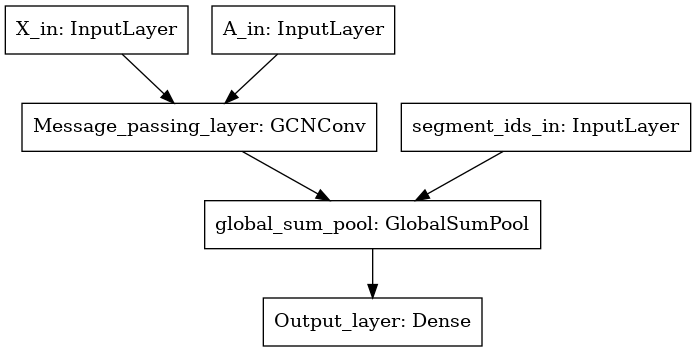

In [8]:
################################################################################
# BUILD MODEL : CE-PE routing Model
################################################################################

# Dataset parameters
F = cepe_dataset.n_node_features  # Dimension of node features
n_out = cepe_dataset.n_labels  # Dimension of the target

# optimizer and loss function (same as CE-PE routing model)
#opt = Adam(lr=learning_rate)
#loss_fn = CategoricalCrossentropy()

cepe_model = CEPE_model.create_model(n_node_features=F, n_labels=n_out, gc_layer=gc_layer, cepe_channels=cepe_channels, learning_rate=learning_rate)  

cepe_model.summary()
plot_model(cepe_model, to_file='../results/CEPE_model.png')

In [9]:
%%time
################################################################################
# TRAIN MODEL : PEs Model
################################################################################

# create Disjoint loaders for train and validation datasets
pes_loader_tr = DisjointLoader(pes_dataset_tr, node_level=True, batch_size=batch_size, epochs=epochs, shuffle=True)
pes_loader_va = DisjointLoader(pes_dataset_va, node_level=True, batch_size=batch_size, shuffle=True)

# train model
pes_model.fit(
    pes_loader_tr.load(),
    steps_per_epoch=pes_loader_tr.steps_per_epoch,
    validation_data=pes_loader_va.load(),
    validation_steps=pes_loader_va.steps_per_epoch,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[EarlyStopping(patience=es_patience, restore_best_weights=True)],
)

1s 43ms/step - loss: 0.4316 - acc: 0.9117 - val_loss: 0.8874 - val_acc: 0.8605
Epoch 325/1000
22/22 [==============================] - 1s 44ms/step - loss: 0.5474 - acc: 0.9003 - val_loss: 0.7919 - val_acc: 0.8775
Epoch 326/1000
22/22 [==============================] - 1s 44ms/step - loss: 0.4692 - acc: 0.9113 - val_loss: 0.6974 - val_acc: 0.8790
Epoch 327/1000
22/22 [==============================] - 1s 45ms/step - loss: 0.4142 - acc: 0.9100 - val_loss: 0.6709 - val_acc: 0.8875
Epoch 328/1000
22/22 [==============================] - 1s 52ms/step - loss: 0.4532 - acc: 0.9063 - val_loss: 0.7240 - val_acc: 0.8915
Epoch 329/1000
22/22 [==============================] - 1s 45ms/step - loss: 0.3782 - acc: 0.9107 - val_loss: 0.6038 - val_acc: 0.8985
Epoch 330/1000
22/22 [==============================] - 1s 47ms/step - loss: 0.4180 - acc: 0.9232 - val_loss: 0.7996 - val_acc: 0.8690
Epoch 331/1000
22/22 [==============================] - 1s 45ms/step - loss: 0.5432 - acc: 0.9002 - val_loss: 0

1/1 [==============================] - 0s 163ms/step - loss: 0.3991 - acc: 0.9388

               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1869
           1       0.99      0.98      0.98       434
           2       0.90      0.92      0.91       427
           3       0.95      0.87      0.91       407
           4       0.95      0.95      0.95       248
           5       0.86      0.96      0.91       159
           6       0.98      0.85      0.91       150
           7       0.92      0.85      0.88       154
           8       0.84      0.93      0.88       152

   micro avg       0.95      0.92      0.94      4000
   macro avg       0.93      0.91      0.92      4000
weighted avg       0.95      0.92      0.94      4000
 samples avg       0.92      0.92      0.92      4000



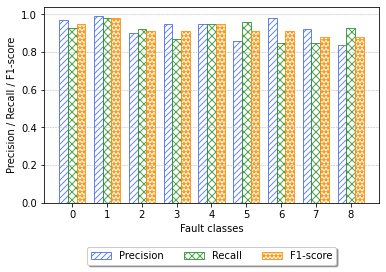

In [10]:
################################################################################
# EVALUATE MODEL : PEs Model
################################################################################
# create a Disjoint loader for test dataset
pes_loader_te = DisjointLoader(pes_dataset_te, node_level=True, batch_size=len(pes_dataset_te), shuffle=True)

batch = pes_loader_te.__next__()
inputs, target = batch

# calculate loss and accuracy values
pes_loss, pes_acc = pes_model.evaluate(pes_loader_te.load(),steps=pes_loader_te.steps_per_epoch)
#print('- loss = ',pes_loss,', - acc = ',pes_acc)

# calculate the classification report
pes_predicted = pes_model(inputs)
pes_report = classification_report(target, np.rint(pes_predicted))
print('\n',pes_report)

png = plot_reports.plot_classification_report(pes_report, '../results/PEs_report.png', title='PEs Classification report')

In [11]:
################################################################################
# SAVE MODEL : PEs Model
################################################################################
pes_model.save_weights('../models/pes_model/ckpt') #, save_format="h5")

pes_model_parameters = {
    'n_nodes'           : pes_dataset[0].n_nodes,
    'n_node_features'   : pes_dataset.n_node_features,  # Dimension of node features
    'n_edge_features'   : pes_dataset.n_edge_features,  # Dimension of edge features
    'n_labels'          : pes_dataset.n_labels,  # Dimension of the target
    'pes_channels'      : pes_channels,
    'learning_rate'     : learning_rate
    }

with open('../models/pes_model/parameters.json', 'w') as outfile:
        json.dump(pes_model_parameters, outfile, indent=4)

In [12]:
%%time
################################################################################
# TRAIN MODEL : CE-PE routing Model
################################################################################

# create Disjoint loaders for train and validation datasets
cepe_loader_tr = DisjointLoader(cepe_dataset_tr, node_level=True, batch_size=batch_size, epochs=epochs, shuffle=True)
cepe_loader_va = DisjointLoader(cepe_dataset_va, node_level=True, batch_size=batch_size, shuffle=True)

# train model
cepe_model.fit(
    cepe_loader_tr.load(),
    steps_per_epoch=cepe_loader_tr.steps_per_epoch,
    validation_data=cepe_loader_va.load(),
    validation_steps=cepe_loader_va.steps_per_epoch,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[EarlyStopping(patience=es_patience, restore_best_weights=True)],
)

Epoch 89/1000
438/438 [==============================] - 4s 10ms/step - loss: 0.1597 - acc: 0.9720 - val_loss: 0.2212 - val_acc: 0.9640
Epoch 90/1000
438/438 [==============================] - 4s 9ms/step - loss: 0.1372 - acc: 0.9740 - val_loss: 0.3166 - val_acc: 0.9585
Epoch 91/1000
438/438 [==============================] - 5s 10ms/step - loss: 0.2136 - acc: 0.9617 - val_loss: 0.1706 - val_acc: 0.9735
Epoch 92/1000
438/438 [==============================] - 4s 10ms/step - loss: 0.1901 - acc: 0.9662 - val_loss: 0.2335 - val_acc: 0.9775
Epoch 93/1000
438/438 [==============================] - 4s 10ms/step - loss: 0.9943 - acc: 0.9615 - val_loss: 0.3176 - val_acc: 0.9510
Epoch 94/1000
438/438 [==============================] - 5s 10ms/step - loss: 0.1705 - acc: 0.9674 - val_loss: 0.3440 - val_acc: 0.9460
Epoch 95/1000
438/438 [==============================] - 4s 10ms/step - loss: 0.5394 - acc: 0.9555 - val_loss: 0.1986 - val_acc: 0.9770
Epoch 96/1000
438/438 [==========================

1/1 [==============================] - 4s 4s/step - loss: 0.1407 - acc: 0.9840

               precision    recall  f1-score   support

           0       0.85      1.00      0.92       213
           1       1.00      1.00      1.00       214
           2       0.99      0.93      0.96       198
           3       1.00      1.00      1.00       171
           4       0.99      0.99      0.99        94
           5       0.99      1.00      1.00       185
           6       0.99      0.95      0.97       177
           7       1.00      1.00      1.00        95
           8       1.00      1.00      1.00        83
           9       0.98      0.96      0.97       192
          10       1.00      1.00      1.00        85
          11       0.97      1.00      0.99       107
          12       1.00      1.00      1.00        77
          13       1.00      0.99      0.99        88
          14       1.00      0.98      0.99       200
          15       1.00      0.99      1.00       180


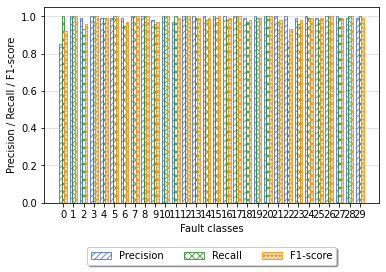

In [13]:
################################################################################
# EVALUATE MODEL : CE-PE routing Model
################################################################################
# create a Disjoint loader for test dataset
cepe_loader_te = DisjointLoader(cepe_dataset_te, batch_size=len(cepe_dataset_te), shuffle=True)

batch = cepe_loader_te.__next__()
inputs, target = batch

# calculate loss and accuracy values
cepe_loss, cepe_acc = cepe_model.evaluate(cepe_loader_te.load(),steps=cepe_loader_te.steps_per_epoch)
#print('- loss = ',cepe_loss,', - acc = ',cepe_acc)

# calculate the classification report
cepe_predicted = cepe_model(inputs)
cepe_report = classification_report(target, np.rint(cepe_predicted))
print('\n',cepe_report)

png = plot_reports.plot_classification_report(cepe_report, '../results/CEPE_report.png', title='CE-PE Classification report')

In [14]:
################################################################################
# SAVE MODEL : CE-PE routing Model
################################################################################
cepe_model.save_weights('../models/cepe_model/ckpt')

cepe_model_parameters = {
    'n_node_features'   : cepe_dataset.n_node_features,  # Dimension of node features
    'n_labels'          : cepe_dataset.n_labels,  # Dimension of the target
    'gc_layer'          : gc_layer,
    'cepe_channels'     : cepe_channels,
    'learning_rate'     : learning_rate
    }

with open('../models/cepe_model/parameters.json', 'w') as outfile:
        json.dump(cepe_model_parameters, outfile, indent=4)